analyze NCI cervical cnv results

In [140]:
# import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind
# import scipy.stats as stats
# import scipy.stats as ss
# from matplotlib import style
# import matplotlib.gridspec as gridspec
# import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
from adjustText import adjust_text

# from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# produce list of amplied and deleted regions with oncogenes

In [264]:
var = 'genes_in_wide_peak'
var1 = '-log10tcga'
var2 = '-log10htmcp'
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_cnv/'

In [265]:
f1 = '/home/szong/projects/resource/oncogenes.and.tumor.suppressor.genes.txt'
df_tg = pd.read_csv(f1, header=None)
df_tg.head()

tgs = df_tg[0].tolist()

,0
0,ABI1
1,ABI2
2,ABL1
3,ABL2
4,ACSL3


In [266]:
def summarize_genes(inf, tgs):
    df = pd.read_csv(inf, sep='\t', header=None)#.replace('', 'None')
#     print(df)
    df.loc['genes',:] = df.apply(lambda x:  ','.join([i.strip() for i in set(x[~x.isnull()][4:]) if ('[' not in i)]))
    df.loc['tg_genes',:] = df.apply(lambda x:  ','.join([m.strip() for m in set(x[~x.isnull()][4:]) if m in tgs]))


    df1 = df.loc[[0,1,2,3,'genes', 'tg_genes'],:].T
    df1['xxx'] = df1.genes.apply(lambda x: x.split(','))
#     '' in the list when there is a blank in the original files, must have a better way to deal with this
    df1['num_genes'] = df1['xxx'].apply(lambda x: len(x) if '' not in x else len(x)-1)
    df1 = df1.drop('xxx', axis=1)
    df1 = df1.drop(0)
    df1 = df1[:-1]
    df1.columns = ['cytoband', 'q_value', 'residual_q_value', 'wide_peak_boundary', 'genes_in_wide_peak','oncogenes','num_genes']
#     df1['cancer_genes'] = df1.apply(lambda x: '({0}){1}'.format(x[4], x[5]), axis=1)
    of = '{}.summary'.format(inf)
    print('write summary for {}'.format(inf))
    df1.to_csv(of, index=False, sep='\t')
    return df1

# 1. TCGA cnv 

In [280]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/Table_Files_Revised_Manuscript2/Supplemental_Table_7-Amp_Del_Peaks.xlsx'
df = pd.read_excel(f, sheet_name='All_amps', header=None)
df = df.astype(str)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,cytoband,11q22.1,3q26.31,20q11.21,8q24.21,3q28,11q13.3,17q25.1,19q13.13,9p24.1,...,6q12,14q11.2,13q34,1p31.3,8p11.21,22q13.31,Xp22.11,11q13.2,2q32.3,19q13.32
1,q value,8.2231e-24,2.0738e-15,6.7744e-10,1.4874e-08,1.3329e-14,1.799e-07,9.4255e-05,2.6629e-05,0.00020757,...,0.10033,0.12486,0.10443,0.17237,0.22602,0.2308,0.23765,0.0005581,0.24581,1.1211e-05
2,residual q value,9.9276e-20,2.4074e-10,6.7744e-10,1.4874e-08,1.3817e-05,4.7655e-05,9.4255e-05,9.475e-05,0.00020757,...,0.10033,0.12486,0.14977,0.17237,0.22602,0.2308,0.23765,0.24448,0.24581,0.41875
3,wide peak boundaries,chr11:101586586-102266642,chr3:172084522-172254680,chr20:30204825-30356590,chr8:128754838-128766079,chr3:189630382-189664399,chr11:69512115-70747182,chr17:72723443-74083947,chr19:38370469-39622696,chr9:5302096-5565600,...,chr6:64272997-65262859,chr14:1-24231912,chr13:76561484-115169878,chr1:61416174-61987969,chr8:33665681-95556587,chr22:34873664-51304566,chrX:1-26768293,chr11:66739730-67775100,chr2:166293014-204085634,chr19:1-59128983
4,genes in wide peak,snoU13|ENSG00000239154.1,GHSR,BCL2L1,MYC,TP63,MIR3664,MYO15B,snoU13|ENSG00000251709.1,RLN1,...,PTP4A1,MIR208B,MIR548AR,NFIA,FSBP,ARSA,VENTXP1,FAM86C2P,SNORA1|ENSG00000202059.1,RN7SL525P


In [281]:
df.loc['genes',:] = df.apply(lambda x:  ','.join([str(i).strip() for i in set(x[~x.isnull()][4:]) if ('[' not in i)]))
df.loc['tg_genes',:] = df.apply(lambda x:  ','.join([m.strip() for m in set(x[~x.isnull()][4:]) if m in tgs]))


df1 = df.loc[[0,1,2,3,'genes', 'tg_genes'],:].T
df1['xxx'] = df1.genes.apply(lambda x: x.split(','))
#     '' in the list when there is a blank in the original files, must have a better way to deal with this
df1['num_genes'] = df1['xxx'].apply(lambda x: len(x) if '' not in x else len(x)-1)
df1 = df1.drop('xxx', axis=1)
df1 = df1.drop(0)
df1 = df1[:-1]
df1.columns = ['cytoband', 'q_value', 'residual_q_value', 'wide_peak_boundary', 'genes_in_wide_peak','oncogenes','num_genes']

df1 = df1[['cytoband', 'q_value', 'wide_peak_boundary', 'genes_in_wide_peak']]
df1.head()

,cytoband,q_value,wide_peak_boundary,genes_in_wide_peak
1,11q22.1,8.2231e-24,chr11:101586586-102266642,"BIRC2,ANGPTL5,nan,BIRC3,snoU13|ENSG00000252679..."
2,3q26.31,2.0738e-15,chr3:172084522-172254680,"MECOM,TERC,nan,TNFSF10,GHSR,FNDC3B"
3,20q11.21,6.7744e-10,chr20:30204825-30356590,"COX4I2,TPX2,nan,BCL2L1"
4,8q24.21,1.4874e-08,chr8:128754838-128766079,"PVT1,MYC,nan"
5,3q28,1.3329e-14,chr3:189630382-189664399,"TP63,nan"


In [282]:
def split_string_into_rows(df1, var):

    df2 = df1.set_index(df1.columns.drop(var,1).tolist())[var].str.split(',', expand=True).stack().reset_index().rename(columns={0:var}).loc[:, df1.columns]
    return df2

In [283]:
df2 = split_string_into_rows(df1, var)

df_tcga_amp = df2[df2[var] != 'nan']

In [284]:
df_tcga_amp.head()
df_tcga_amp.shape

,cytoband,q_value,wide_peak_boundary,genes_in_wide_peak
0,11q22.1,8.2231e-24,chr11:101586586-102266642,BIRC2
1,11q22.1,8.2231e-24,chr11:101586586-102266642,ANGPTL5
3,11q22.1,8.2231e-24,chr11:101586586-102266642,BIRC3
4,11q22.1,8.2231e-24,chr11:101586586-102266642,snoU13|ENSG00000252679.1
5,11q22.1,8.2231e-24,chr11:101586586-102266642,TRPC6


(2350, 4)

In [285]:
df_tcga_amp = df_tcga_amp.drop_duplicates(subset=[var])

In [286]:
df_tcga_amp.shape

(2350, 4)

# 2. HTMCP results

In [287]:
# f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/del_genes.conf_99.txt'
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/amp_genes.conf_99.txt'
df_htmcp1 = summarize_genes(f, tgs)

write summary for /home/szong/bin/GISTIC_2_0_22/gatk_118_patients/amp_genes.conf_99.txt


In [288]:
df_htmcp1.head()
df_htmcp1.shape

,cytoband,q_value,residual_q_value,wide_peak_boundary,genes_in_wide_peak,oncogenes,num_genes
1,1q22,4.1908e-32,8.4844e-28,chr1:155181002-155213123,"GBA,GBAP1,MTX1",,3
2,5p15.33,1.4318e-21,3.8102e-19,chr5:765002-776999,,,0
3,11q22.1,2.0542e-14,2.0542e-14,chr11:101742607-102370999,"BIRC2,ANGPTL5,BIRC3,TMEM123,YAP1,KIAA1377,C11o...","BIRC3,YAP1",7
4,15q11.2,2.6307e-14,7.7724e-14,chr15:20445002-22297999,"NF1P2,LOC727924,HERC2P3,GOLGA6L6,GOLGA8C,hsa-m...",,13
5,3q29,6.4129e-14,2.4179e-11,chr3:195431002-195454999,MUC20,,1


(53, 7)

In [289]:
df_htmcp2 = split_string_into_rows(df_htmcp1, var)

df_htmcp_amp = df_htmcp2[df_htmcp2[var] != 'nan']

In [290]:
df_htmcp_amp.head()
df_htmcp_amp.shape

,cytoband,q_value,residual_q_value,wide_peak_boundary,genes_in_wide_peak,oncogenes,num_genes
0,1q22,4.1908e-32,8.4844e-28,chr1:155181002-155213123,GBA,,3
1,1q22,4.1908e-32,8.4844e-28,chr1:155181002-155213123,GBAP1,,3
2,1q22,4.1908e-32,8.4844e-28,chr1:155181002-155213123,MTX1,,3
3,5p15.33,1.4318e-21,3.8102e-19,chr5:765002-776999,,,0
4,11q22.1,2.0542e-14,2.0542e-14,chr11:101742607-102370999,BIRC2,"BIRC3,YAP1",7


(769, 7)

In [291]:
df_htmcp_amp = df_htmcp_amp.drop_duplicates(subset=[var])

In [292]:
cols = ['q_value', var]
dft = df_tcga_amp[cols]
dfh = df_htmcp_amp[cols]
dfm = pd.merge(dft, dfh, left_on=var, right_on=var, how='outer').fillna(1)

In [293]:
dfm.head()
dfm.shape

,q_value_x,genes_in_wide_peak,q_value_y
0,8.2231e-24,BIRC2,2.0542e-14
1,8.2231e-24,ANGPTL5,2.0542e-14
2,8.2231e-24,BIRC3,2.0542e-14
3,8.2231e-24,snoU13|ENSG00000252679.1,1
4,8.2231e-24,TRPC6,1


(2911, 3)

In [294]:
# dfm[var].value_counts()

In [295]:
dfm = dfm[dfm[var] != '']

In [296]:
dfm = dfm[~dfm[var].str.contains('ENSG')]

In [297]:
dfm = (dfm.set_index(var)).astype(float)

In [298]:
dfm['-log10tcga'] = - np.log10(dfm['q_value_x'])
dfm['-log10htmcp'] = - np.log10(dfm['q_value_y'])

In [299]:
dfm.q_value_x.describe()

count    2.775000e+03
mean     3.037206e-01
std      3.598614e-01
min      8.223100e-24
25%      7.572400e-02
50%      2.260200e-01
75%      2.458100e-01
max      1.000000e+00
Name: q_value_x, dtype: float64

In [300]:
len(set(dfm.index.tolist()))

2775

In [301]:
# dfk = dfm.sort_values(var2, ascending=False)
# dfk.drop_duplicates(keep='first')

In [302]:
dfm.head(3)
dfm.shape

,q_value_x,q_value_y,-log10tcga,-log10htmcp
genes_in_wide_peak,,,,
BIRC2,8.223100e-24,2.054200e-14,23.084964,13.687357
ANGPTL5,8.223100e-24,2.054200e-14,23.084964,13.687357
BIRC3,8.223100e-24,2.054200e-14,23.084964,13.687357


(2775, 4)

In [303]:
dfm.shape

(2775, 4)

In [304]:
len(text1)

143

In [323]:
for i in dfm.sort_values(var2, ascending=False).index.tolist()[:30]:
    print(i)

GBAP1
GBA
MTX1
GUSBP1
ANGPTL5
TMEM123
BIRC2
YAP1
BIRC3
C11orf70
KIAA1377
GOLGA6L6
HERC2P3
NF1P2
GOLGA8C
hsa-mir-3118-4
LOC348120
NBEAP1
hsa-mir-3118-6
CHEK2P2
CXADRP2
LOC646214
POTEB
LOC727924
MUC20
FAM66D
OR4K2
OR4K1
OR4Q3
OR4K5


In [308]:

len(set(dfm[(dfm[var1]>0.1)&(dfm[var2]>0.1)].index.tolist()))
for i in dfm[(dfm[var1]>0.1)&(dfm[var2]>0.1)].index.tolist():
    print(i)

189

BIRC2
ANGPTL5
BIRC3
YAP1
KIAA1377
C11orf70
COX4I2
TPX2
BCL2L1
TP63
APIP
EHF
MIR1343
PDHX
GBA
GBAP1
MTX1
MIR4515
AP3B2
CRTC3
HDGFRP3
FAM174B
BLM
UBE2Q2P3
ANPEP
MEF2A
SV2B
SEMA4B
CHSY1
MIR3175
HAPLN3
MCTP2
LRRC28
AEN
TTLL13
RHCG
HDDC3
PRC1
SNRPA1
PGPEP1L
MIR1276
UBE2Q2P2
ZNF710
WDR93
HOMER2
MESP2
FAM169B
ABHD2
LINS
NGRN
PCSK6
DDX11L9
MAN2A2
SLC28A1
RPS17
BNC1
ARRDC4
TM6SF1
FSD2
ALDH1A3
LRRK1
C15orf32
PLIN1
LINC00052
GOLGA6L5
TM2D3
SEC11A
IGF1R
DNM1P46
RGMA
ADAMTSL3
KIF7
AP3S2
UBE2Q2P1
NR2F2
FAM138E
KLHL25
FAM103A1
CIB1
MESP1
GABARAPL3
ASB7
OR4F4
OR4F15
RLBP1
FES
IDH2
C15orf38
VPS33B
CPEB1
WDR73
TARSL2
CERS3
MIR1469
FURIN
SPATA8
PDE8A
RCCD1
SLCO3A1
AGBL1
MRPS11
FANCI
WASH3P
SYNM
ZNF592
NMB
ISG20
FAM154B
DET1
IQGAP1
C15orf40
WHAMM
MFGE8
EFTUD1
BTBD1
UNC45A
ADAMTS17
LYSMD4
RPS17L
NTRK3
CHD2
ALPK3
MRPL46
ZNF774
SH3GL3
MIR4714
AKAP13
MIR1179
OR4F6
ACAN
ZSCAN2
ST8SIA2
PEX11A
POLG
TTC23
OR4K5
OR4M1
OR4Q3
OR4K1
OR4K2
OR4N2
NFIA
RRP7A
SERHL
SERHL2
HOXD11
TTC30B
NFE2L2
SESTD1
HOXD12
MIR3128
MIR10B

In [345]:
dfm.head(2)
dfn = dfm[(dfm[var1] > 1)&(dfm[var2] > 1)]
ix= dfn.index
dfn2 = dfm[(dfm[var1] > 10)|(dfm[var2] > 10)]
dfn2.shape
ix2 = dfn2.index
to_drop = [i for i in ix2 if i in ix]
to_drop
ix3 = dfn2.index.drop(to_drop)
dfn2.loc[ix3,]
# dfn2.drop()

,q_value_x,q_value_y,-log10tcga,-log10htmcp
genes_in_wide_peak,,,,
BIRC2,8.223100e-24,2.054200e-14,23.084964,13.687357
ANGPTL5,8.223100e-24,2.054200e-14,23.084964,13.687357


(32, 4)

['BIRC2',
 'ANGPTL5',
 'BIRC3',
 'YAP1',
 'KIAA1377',
 'C11orf70',
 'TP63',
 'GBA',
 'GBAP1',
 'MTX1']

,q_value_x,q_value_y,-log10tcga,-log10htmcp
genes_in_wide_peak,,,,
TRPC6,8.223100e-24,1.000000e+00,23.084964,-0.000000
MECOM,2.073800e-15,1.000000e+00,14.683233,-0.000000
TERC,2.073800e-15,1.000000e+00,14.683233,-0.000000
TNFSF10,2.073800e-15,1.000000e+00,14.683233,-0.000000
GHSR,2.073800e-15,1.000000e+00,14.683233,-0.000000
FNDC3B,2.073800e-15,1.000000e+00,14.683233,-0.000000
TMEM123,1.000000e+00,2.054200e-14,-0.000000,13.687357
NF1P2,1.000000e+00,2.630700e-14,-0.000000,13.579929
LOC727924,1.000000e+00,2.630700e-14,-0.000000,13.579929


39

['BIRC2',
 'ANGPTL5',
 'BIRC3',
 'YAP1',
 'KIAA1377',
 'C11orf70',
 'TP63',
 'GBA',
 'GBAP1',
 'MTX1']

133

CPU times: user 1.24 s, sys: 92 ms, total: 1.33 s
Wall time: 1.37 s


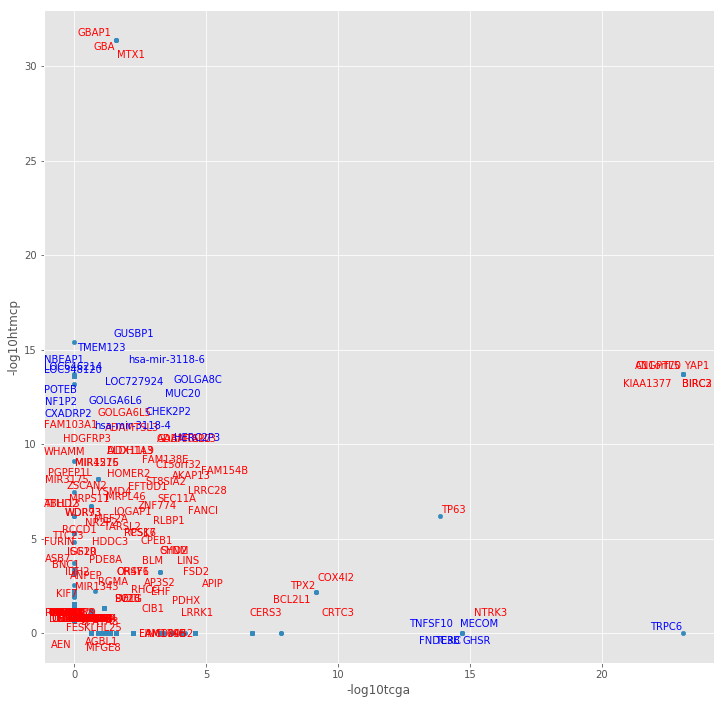

In [348]:

dfm=dfm.fillna(1)
dfm.rename(index={'MLL2':'KMT2D'}, inplace=True)
dfm.plot.scatter(var1, var2, figsize=(12,12)) #, xlim=(-2, 40), ylim=(-2, 40))
# plt.hlines(1, 0, 50, colors='r', linestyles='dashed')
# plt.vlines(1, 0, 12, colors='r', linestyles='dashed')
# plt.ylabel('-log10(q)', fontsize=10)
dfn = dfm[(dfm[var1] > 1)&(dfm[var2] > 1)]
# dfn = dfm[(dfm[var1] > .6)&(dfm[var2] > .6)|(dfm[var1] > 10)|(dfm[var2] > 20)]
text1 = [plt.text(a, b, c, color='red') for a, b, c in zip(dfn[var1], dfn[var2], dfn.index)]
adjust_text(text1)


ix= dfn.index





dfn2 = dfm[(dfm[var1] > 10)|(dfm[var2] > 10)]

# texts = text1+text2
ix2 = dfn2.index
to_drop = [i for i in ix2 if i in ix]
to_drop
ix3 = dfn2.index.drop(to_drop)
dfn3 = dfn2.loc[ix3,]
# text3 = [i for i in text2 if i not in text1]
text3 = [plt.text(a, b, c, color='blue') for a, b, c in zip(dfn3[var1], dfn3[var2], dfn3.index)]
adjust_text(text3)

of = f'{wkdir}htmcp_tcga_shared_uniq_amp_genes.png'
%time plt.savefig(of, bbox_inches='tight',dpi=200)
plt.show()

In [310]:
dfamp = dfm.copy()

In [487]:
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/del_genes.conf_99.txt', 
#          '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/amp_genes.conf_99.txt'] 
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/del_genes.conf_99.txt',
#          '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/amp_genes.conf_99.txt']
files = ['/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/del_genes.conf_99.txt',
#         '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt']
for inf in files:
    df1 = summarize_genes(inf, tgs)

write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/del_genes.conf_99.txt
write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt


In [488]:
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/del_genes.conf_99.txt', 
#          '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/amp_genes.conf_99.txt'] 
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/del_genes.conf_99.txt', 
# '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/amp_genes.conf_99.txt']
files = ['/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/del_genes.conf_99.txt',
        '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/amp_genes.conf_99.txt']

for inf in files:
    df1 = summarize_genes(inf, tgs)

write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/del_genes.conf_99.txt
write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/amp_genes.conf_99.txt


In [489]:
%%bash
cd /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

cd /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

In [192]:
def get_qvalue_cytoband(f):
    df = pd.read_csv(f, sep='\t')
    df['gene'] = df['oncogenes'].apply(lambda x: x.split(')')[1])
    df = df[['q value','cytoband', 'gene']]
    df = df[df.gene != '']
    s = df["gene"].str.split(',', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2["gene"] = s.values
    return df2

In [272]:
def map_two_columns(x1, x2):
    if 'q' in x1 or 'p' in x1:
        return x1
    elif 'q' in x2 or 'p' in x2:
        return x2
    else:
        return 'error'
    

In [280]:
# for amps
# pos_amp_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'
pos_amp_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'
pos_amps = get_qvalue_cytoband(pos_amp_file)
pos_amps.head(2)

# neg_amp_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/amp_genes.conf_99.txt.summary.sorted'
neg_amp_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/amp_genes.conf_99.txt.summary.sorted'
neg_amps = get_qvalue_cytoband(neg_amp_file)
neg_amps.head(2)

ndf = pd.merge(pos_amps, neg_amps, left_on='gene', right_on='gene', how='outer')#.fillna(1)
ndf.columns = ['hiv+q', 'cytoband_pos','gene', 'hiv-q', 'cytoband_neg']
ndf['cytoband'] = ndf.astype(str).apply(lambda x: map_two_columns(x1=x['cytoband_pos'], x2=x['cytoband_neg']), axis=1)

ndf = ndf.drop(['cytoband_pos', 'cytoband_neg'], axis=1)
ndf.head(2)

,q value,cytoband,gene
7,0.003377,2q31.1,NFE2L2
7,0.003377,2q31.1,HOXD11


,q value,cytoband,gene
2,0.19405,2p25.3,C2orf44
2,0.19405,2p25.3,NCOA1


,hiv+q,gene,hiv-q,cytoband
0,0.003377,NFE2L2,NaN,2q31.1
1,0.003377,HOXD11,NaN,2q31.1


In [281]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/amp_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf.to_csv(of, sep='\t', index=False)

In [314]:
# for dels
pos_del_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/del_genes.conf_99.txt.summary.sorted'
pos_dels = get_qvalue_cytoband(pos_del_file)
pos_dels.head(2)

neg_del_file = '//projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/del_genes.conf_99.txt.summary.sorted'
neg_dels = get_qvalue_cytoband(neg_del_file)
neg_dels.head(2)

ndf = pd.merge(pos_dels, neg_dels, left_on='gene', right_on='gene', how='outer')#.fillna(1)
ndf.columns = ['hiv+q', 'cytoband_pos','gene', 'hiv-q', 'cytoband_neg']
ndf['cytoband'] = ndf.astype(str).apply(lambda x: map_two_columns(x1=x['cytoband_pos'], x2=x['cytoband_neg']), axis=1)

ndf = ndf.drop(['cytoband_pos', 'cytoband_neg'], axis=1)
ndf.head(2)

,q value,cytoband,gene
0,0.055942,1p36.21,MDS2
0,0.055942,1p36.21,PARK7


,q value,cytoband,gene
0,0.039246,1p13.2,GSTM1
0,0.039246,1p13.2,RAP1A


,hiv+q,gene,hiv-q,cytoband
0,0.055942,MDS2,NaN,1p36.21
1,0.055942,PARK7,NaN,1p36.21


In [92]:
ndf.shape
ndf['gene'].nunique()

(431, 3)

414

In [93]:
# look at duplicated on column gene
pd.concat(g for _, g in ndf.groupby("gene") if len(g) > 1).head(2)

,hiv+q,gene,hiv-q
20,1.795800e-19,ACSL3,1.0
21,1.855100e-18,ACSL3,1.0


In [315]:
ndf = ndf.drop_duplicates(subset='gene', keep='last')

In [283]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    k = 0
    j = 0 
    for i, point in a.iterrows():
        _ = ax.text(point['x']+j, point['y']+k, str(point['val']))
        k+=1
#         j+=.5
    return a

In [36]:
def plot_genes(ax, df):
    df = df.sort_values(['y', 'x'], ascending=True)
    for ix, row in df.iterrows():  
        gene = row.gene
        x = row['hiv+q']
        y = row['hiv-q']
        textx = row.x
        texty = row.y
#         anno_color = row.anno_color
#         anno_ecolor = row.anno_ecolor
#         arrow_color = row.arrow_color
#         fill_color = row.fill_color
        anno_color = 'blue'
        arrow_color = 'blue'
        ax.annotate('{}'.format(gene),
                    xy=(x,y), 
                    xytext=(textx, texty), fontsize=10,
                    ha='center', va='bottom', color=anno_color,
                    textcoords='data', xycoords="data", 
                    bbox=dict(boxstyle='round', 
#                               fc=fill_color, 
#                               edgecolor=anno_ecolor,
                              alpha=1, pad=.4),
                    arrowprops=dict(arrowstyle='-', 
                                    color=anno_color,
                                    shrinkB=0, 
                                    connectionstyle='arc3,rad=0.0' 
                                  ))

In [10]:
ndf = ndf.sort_values('hiv-q')

In [318]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf = pd.read_csv(of, sep='\t').fillna(1)
ndf.head(2)

,hiv+q,gene,hiv-q,cytoband
0,0.055942,MDS2,1.0,1p36.21
1,0.055942,PARK7,1.0,1p36.21


In [319]:
ndf['hiv+q(-log10)'] = -np.log10(ndf['hiv+q'])
ndf['hiv-q(-log10)'] = -np.log10(ndf['hiv-q'])

In [320]:
ndf.head()
ndf.shape

,hiv+q,gene,hiv-q,cytoband,hiv+q(-log10),hiv-q(-log10)
0,0.055942,MDS2,1.0,1p36.21,1.252262,-0.0
1,0.055942,PARK7,1.0,1p36.21,1.252262,-0.0
2,0.055942,RAP1GAP,1.0,1p36.21,1.252262,-0.0
3,0.055942,KIF1B,1.0,1p36.21,1.252262,-0.0
4,0.055942,SDHB,1.0,1p36.21,1.252262,-0.0


(414, 6)

Text(0.5,1,'GISTIC dels oncogenes')

(-1, 23)

(-1, 23)

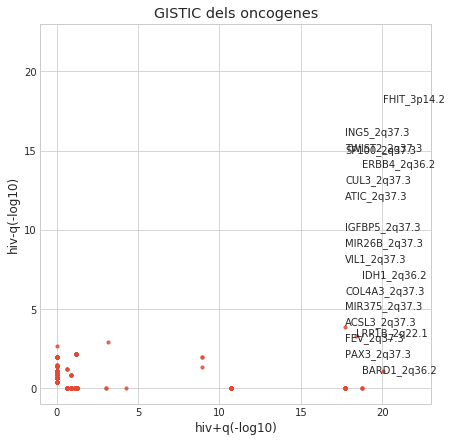

In [321]:
# Set theme
sns.set_style('whitegrid')


# Scatterplot arguments
# grid = sns.lmplot(x='hiv+q', y='hiv-q', data=ndf.fillna(.1),
#            fit_reg=False) # No regression line
#            #hue='Stage')   # Color by evolution stage
# # Tweak using Matplotlib
# # plt.ylim(0, .2)
# # plt.xlim(0, .2)
# grid.set(xscale="log", yscale="log")

f, ax = plt.subplots(figsize=(7, 7))


# ax.set(xscale="log", yscale="log")
sns.regplot(x='hiv+q(-log10)', y='hiv-q(-log10)', data=ndf, ax=ax, fit_reg=False, x_jitter=1e-12, y_jitter=1e-10, scatter_kws={"s": 10})




ax.set_title('GISTIC dels oncogenes')
ax.set_xlim(-1, 23)
ax.set_ylim(-1, 23)



    
ndf = ndf[(ndf['hiv+q(-log10)']>15)]#|(ndf['hiv-q(-log10)']>5)]
_ = label_point(ndf['hiv+q(-log10)'], ndf['hiv-q(-log10)'], ndf['gene']+'_'+ndf['cytoband'], plt.gca())  
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.png'
plt.savefig(of, bbox_inches='tight', dpi=200)

In [126]:
plt.close()

In [18]:
ndf.head(2)

,hiv+q,gene,hiv-q
23,1.0,TP63,1.264200e-10
25,1.0,MYC,5.258800e-03


In [316]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf.to_csv(of, sep='\t', index=False)

In [9]:
%%bash
cd /home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

# look at correlation between copy number and expression

In [49]:
df2

,q value,gene,new_gene
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",NFE2L2
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD11
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD13
9,8.332900e-13,DLG1,DLG1
16,5.524600e-02,RAC1,RAC1
20,6.399600e-05,ESRP1,ESRP1
22,8.899700e-02,UHRF2,UHRF2
26,1.518200e-01,"LMO2,EHF",LMO2
26,1.518200e-01,"LMO2,EHF",EHF
28,5.902500e-07,"YAP1,BIRC3",YAP1


In [ ]:
f = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/all_thresholded.by_genes.txt'
df = pd.read_csv(f, sep='\t')
df.head(2)

In [ ]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/NCI_ensembl69_stranded_RPKM_matrix.txt'
df1 = pd.read_csv(f1, sep='\t')
df1.head(2)

In [ ]:
genes = ['ECT2', 'YAP1', 'DLG1',  'DNAH5',  'SP100', 'STK11']

In [ ]:
def categorize_cnv(i):
#     for i in s:
    if i < 0:
        cat = 'cnv_loss'
    elif i > 0:
        cat = 'cnv_gain'
    else: cat = 'cnv_neutral'
#         ns.append(cat)
    return cat

In [ ]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(12,12))
    axes = (fig.subplots(int(len(genes)/3), 3)).ravel()
#     print(axes[1])
    for i, gene in enumerate(genes):
        dfgene = df[df['Gene Symbol'] == gene]
        df1gene = df1[df1.genes.str.contains('_{}$'.format(gene))]
        dff = pd.concat([dfgene, df1gene]).drop(['Cytoband', 'Gene Symbol', 'Locus ID', 'genes'], axis=1).T
        dff.columns = ['cnv', 'rpkm']
#         dff['groups'] = ['cnv_loss' if i< 0 'cnv_gain' elif i>0 else 'cnv_neutral' for i in dff.cnv ]
        dff['groups'] = dff.cnv.apply(categorize_cnv)
#         print(dff['groups'].unique())
        # boxplot overlaps individual data point

        ax = axes[i]
        _ = sns.boxplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = sns.swarmplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = ax.set_title(gene)
        _ = ax.set_xlabel('')
        grps = {}
        # overlay actuall data point
        categories = ['cnv_loss','cnv_neutral', 'cnv_gain']
        group_col = 'groups'
        value_col = 'rpkm'
        for i, cat in enumerate(categories):
#             print(i, cat)
            grps[i] = dff.query('{0} == "{1}"'.format(group_col, cat))[value_col]

        if len(categories) == 2:
            # statistical test for 1st grp
#             sts, p = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p)
            p = round(p, 8)
            _ = ax.text(0.4 , 0.90,'p={}'.format(p), ha='center', va='center', transform=ax.transAxes, size=14)
        elif len(categories) == 3:
            # statistical test for 1st grp
#             sts, p1 = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p1)
            p1 = round(p1, 5)
            _ = ax.text(0.2 , 0.90,'p={}'.format(p1), ha='center', va='center', transform=ax.transAxes, size=14)
#             sts, p2 = ss.mannwhitneyu(grps[2], grps[1], use_continuity=True, alternative=None)
            sts, p2 = ttest_ind(grps[2], grps[1])
#             print(p2)
            p2 = round(p2, 5)
            _ = ax.text(0.7 , 0.90,'p={}'.format(p2), ha='center', va='center', transform=ax.transAxes, size=14)
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_expression.png'
    plt.savefig(of, dpi=200)